# Remake Figure 3

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import progressbar
import scipy.stats

import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# import dimer_network_utilities
# importlib.reload(dimer_network_utilities)
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [5]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [6]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 72,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Colors

In [8]:
okabe_ito_colors=[
        (0, 0, 0), # Black
        (230, 159, 0), # Orange
        (86, 180, 233), # Sky Blue
        (0, 158, 115), # Green
        (240, 228, 66), # Yellow
        (213, 94, 0), # Vermilion
        (0, 114, 178), # Blue
        (204, 121, 167), # Pink
        (150, 150, 150), # Gray
        ]

okabe_ito_colors = [tuple([x/255 for x in color]) for color in okabe_ito_colors]

okabe_ito_cmap = mcolors.LinearSegmentedColormap.from_list(\
                        name=f'okabe_ito',\
                        colors=okabe_ito_colors,N=len(okabe_ito_colors))


triple_colors = [
        (171,108,0), # Brown
        (64,176,166), # Teal
        (122, 68, 194), # Purple
]

triple_colors = [tuple([x/255 for x in color]) for color in triple_colors]

triple_cmap = mcolors.LinearSegmentedColormap.from_list(\
                        name=f'triple',\
                        colors=triple_colors,N=len(triple_colors))

In [9]:
tab10_cmap_reordered_list = [
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), # Brown
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), # Green
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353), # Purple
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), # Blue
    (1.0, 0.4980392156862745, 0.054901960784313725), # Orange
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), # Red
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), # Pink
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), # Gray
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), # Green Yellow
    # (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
]

paramset_cmap10_list = [
    triple_colors[0], # Brown
    triple_colors[1], # Greenish
    triple_colors[2], # Purple
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), # Blue
    (1.0, 0.4980392156862745, 0.054901960784313725), # Orange
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), # Red
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), # Pink
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), # Gray
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), # Green Yellow
    # (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
]

paramset_cmap10 = mcolors.LinearSegmentedColormap.from_list(\
                        name=f'cmap10',\
                        colors=paramset_cmap10_list,N=len(paramset_cmap10_list))

## Simulation Functions

In [10]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [11]:
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

## Figure 3A

Tunable 1D bandpass filter

#### Define Parameter Sets

In [11]:
m = 3
num_inputs = 1

t = 60 # Number of input points to simulate
input_lb = -3 # Lower bound of input range, in log space
input_ub = 3 # Upper bound of input range, in log space

In [12]:
param_sets_versatile = {
    'low': np.array([1e-10, 1e+03, 1e+00, 1e-10, 1e+03, 1e+00,
        1e0,8e-1]),
    'medium': np.array([1e-10, 1e+03, 1e+00, 1e-10, 1e+03, 1e+00,
        8e+0, 2e0]),
    'high': np.array([1e-10, 1e+03, 1e+00, 1e-10, 1e+03, 1e+00,
        8e+1, 6e0]),
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)


In [13]:
meta_name = 'tunable-1D-bandpass'
names_to_plot = list(param_sets_versatile.keys())

### Plot the schematic:

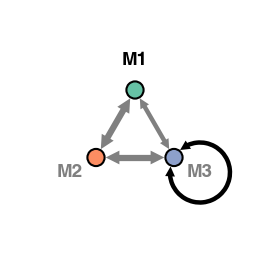

In [20]:
save = True

K = param_sets_versatile[names_to_plot[0]][:-(m-num_inputs)]

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0), # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]),
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        ) 

fig.set_dpi(150)

if save:
    filename = f'Fig3A_{m}M_{meta_name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

### Plot the accessory expression levels:

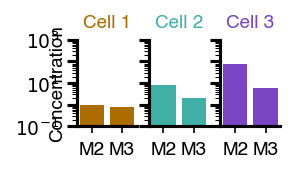

In [34]:
save = True

fig, axs = plt.subplots(figsize=(1.75,0.75),nrows=1,ncols=len(names_to_plot),sharex=True,sharey=True,)

paramset_cmap = triple_cmap.copy()

for name_i, name in enumerate(names_to_plot):
    param_set = param_sets_versatile[name]
    A = param_set[-(m-num_inputs):]
    _ = axs[name_i].bar(list(range(m-num_inputs)),A,width=0.8,color=paramset_cmap(name_i))

    _ = axs[name_i].set_title(f'Cell {name_i+1}',color=paramset_cmap(name_i))

    _ = axs[name_i].set_xticks(list(range(m-num_inputs)))
    _ = axs[name_i].set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = axs[name_i].set_yscale('log')
    _ = axs[name_i].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    _ = axs[name_i].set_ylim([1e-1,1e3])
    
    # Set yticks
    set_simple_log_ticks(axs[name_i],which='y',log_lowerbound=-1,log_upperbound=3,max_labels=4)

    # Customize spines
    axs[name_i].spines.right.set_visible(False)
    axs[name_i].spines.top.set_visible(False)
    set_spine_linewidth(axs[name_i],1)

    # Customize the major ticks
    axs[name_i].tick_params(axis='y', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[name_i].tick_params(axis='y', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks
   
_ = fig.supylabel('Concentration',fontsize=9)

fig.set_dpi(150)

fig.patch.set_facecolor('white')
if save:
    filename = f'Fig3A_{m}M_{meta_name}_accessory_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot the Responses:

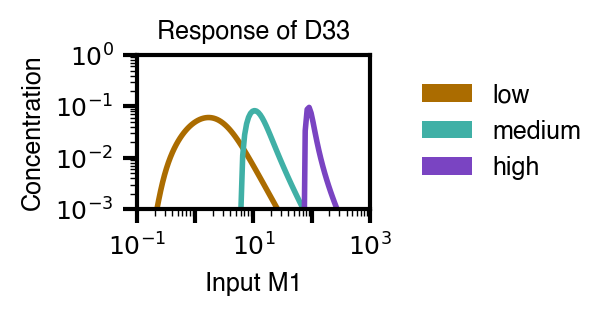

In [39]:
save = True

t=120
input_lb = -1
input_ub = 3

y_range = [1e-3,1e0]

x_points = list(10**np.linspace(input_lb,input_ub,t,endpoint=True))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(1.5,1))
paramset_cmap = triple_cmap.copy()

for name_i, name in enumerate(names_to_plot):
    param_set = param_sets_versatile[name]
    C0,S_all  = simulate_networks(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
    ax.plot(x_points,S_all[:,m+dimer_of_interest,0],marker=None,linestyle='-',color=paramset_cmap(name_i),\
                        alpha=1,lw=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim(y_range)

ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-1,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=0,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = ax.set_xlabel('Input M1')
_ = ax.set_ylabel('Concentration')
_ = ax.set_title('Response of {}'.format(make_nXn_species_names(m)[m+dimer_of_interest].replace('_','')))

patches={}
for name_i, name in enumerate(names_to_plot):
    patches[f'{name}'] = mpatches.Patch(facecolor=paramset_cmap(name_i),linewidth=0,linestyle='',\
                                                alpha=1,label=f'{name}',edgecolor=None)

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

fig.set_dpi(200)

if save:
    filename = f'Fig3A_{m}M_{meta_name}_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 3B

#### Bump and Step Down

In [45]:
m = 3
num_inputs = 1

t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range, in log space
input_ub = 3 # Upper bound of input range, in log space

In [22]:
param_sets_versatile = {
    'bump': np.array([1.00000000e-03, 1.00000000e+04, 6.34896907e+02, 1.30583796e-03,
                    1.00000000e+04, 1.89323935e+02, 22,20]),
    'stepdown': np.array([1.00000000e-03, 1.00000000e+04, 6.34896907e+02, 1.30583796e-03,
                    1.00000000e+04, 1.89323935e+02, 1, 10])
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)

In [23]:
meta_name = 'bump-stepdown-versatile'
names_to_plot = ['bump','stepdown']

#### Step Up and Step Down

In [40]:
m = 3
num_inputs = 1

In [41]:
param_sets_versatile = {
    'stepdown': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 1.00000000e-01, 1.34942191e+00]),
    'stepup': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 2.62756786e+02, 2.61698411e+02]),
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)


In [42]:
meta_name = 'stepup-stepdown-versatile'
names_to_plot = list(param_sets_versatile.keys())

### Plot the schematic:

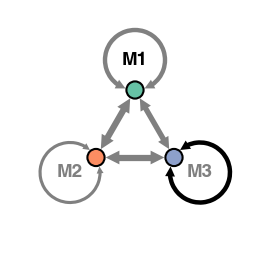

In [44]:
save = True

K = param_sets_versatile[names_to_plot[0]][:-(m-num_inputs)]

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0), # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]),
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        )

fig.set_dpi(150)

if save:
    filename = f'Fig3B_{m}M_{meta_name}_{name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

### Plot the accessory expression levels:

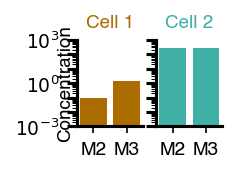

In [54]:
save = True

fig, axs = plt.subplots(nrows=1,ncols=len(names_to_plot), figsize=(1.25,0.75),sharey=True,sharex=True)

paramset_cmap = triple_cmap.copy()

for name_i,name in enumerate(names_to_plot):
    param_set = param_sets_versatile[name]
    A = param_set[-(m-num_inputs):]
    _ = axs[name_i].bar(list(range(m-num_inputs)),A,width=0.8,color=paramset_cmap(name_i))
    _ = axs[name_i].set_title(f'Cell {name_i+1}',color=paramset_cmap(name_i))

    _ = axs[name_i].set_xticks(list(range(m-num_inputs)))
    _ = axs[name_i].set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = axs[name_i].set_yscale('log')
    _ = axs[name_i].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    _ = axs[name_i].set_ylim([1e-3,1e3])

    # Set yticks
    set_simple_log_ticks(axs[name_i],which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

    # Customize spines
    axs[name_i].spines.right.set_visible(False)
    axs[name_i].spines.top.set_visible(False)
    set_spine_linewidth(axs[name_i],1)

    # Customize the major ticks
    axs[name_i].tick_params(axis='y', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[name_i].tick_params(axis='y', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = fig.supylabel('Concentration',fontsize=9)

fig.set_dpi(150)

fig.patch.set_facecolor('white')
if save:
    filename = f'Fig3B_{m}M_{meta_name}_accessory_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot the Responses:

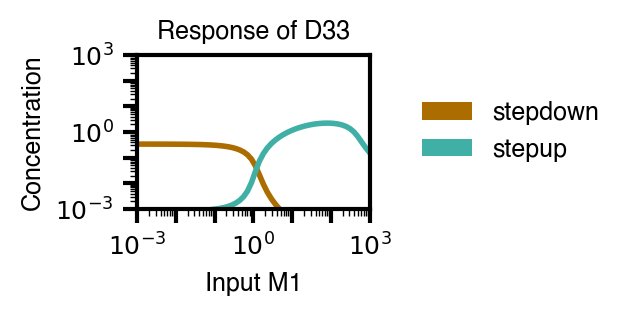

In [58]:
save = True

t=60
input_lb = -3
input_ub = 3

fig, ax = plt.subplots(figsize=(1.5,1))

paramset_cmap = triple_cmap.copy()

x_points = list(10**np.linspace(input_lb,input_ub,t,endpoint=True))

for name_i,name in enumerate(names_to_plot):
    param_set = param_sets_versatile[name]
    C0,S_all  = simulate_networks(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
    
    ax.plot(x_points,S_all[:,m+dimer_of_interest,0],marker=None,linestyle='-',color=paramset_cmap(name_i),\
                        alpha=1,lw=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim([10**-3,10**3])

ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-3,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = ax.set_xlabel('Input M1')
_ = ax.set_ylabel('Concentration')
_ = ax.set_title('Response of {}'.format(make_nXn_species_names(m)[m+dimer_of_interest].replace('_','')))

patches={}
for name_i, name in enumerate(names_to_plot):
    patches[f'{name}'] = mpatches.Patch(facecolor=paramset_cmap(name_i),linewidth=0,linestyle='',\
                                                alpha=1,label=f'{name}',edgecolor=None)

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

fig.set_dpi(200)

if save:
    filename = f'Fig3B_{m}M_{meta_name}_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 3C

The "versatile" two-input bandpass filter.

### Define Parameter Sets

In [12]:
num_inputs = 2
m=5
dimer_of_interest = make_nXn_species_names(m).index('D_5_5') - m # Index of dimer to use as output (D_1_1 = index 0)
meta_name = 'double_bandpass_tunable' 
param_sets = np.array([[1e-10, 1e-10, 1e-10, 10000.0, 20.0, 1e-10, 10000.0, 1e-10, 20.0, 1e-10, 1e-10, 10000.0, 1e-10, 10000.0, 1000.0,1e0,1e0,1.5e-1]])
K = param_sets[0,:num_combos_with_replacement(m,2)]

In [13]:
# Accessory expression levels
A_sets = {
    1:{
    'M3': 1e2,
    'M4': 1e0,
    'M5': 1e0,
    },
    2:{
    'M3': 1e2,
    'M4': 1e1,
    'M5': 2e0,
    },
    3:{
    'M3': 1e2,
    'M4': 1e2,
    'M5': 7e0,
    },
    4:{
    'M3': 1e1,
    'M4': 1e0,
    'M5': 5e-1,
    },
    5:{
    'M3': 1e1,
    'M4': 1e1,
    'M5': 2e0,
    },
    6:{
    'M3': 1e1,
    'M4': 1e2,
    'M5': 2e0,
    },
    7:{
    'M3': 1e0,
    'M4': 1e0,
    'M5': 1.5e-1,
    },
    8:{
    'M3': 1e0,
    'M4': 1e1,
    'M5': 5e-1,
    },
    9:{
    'M3': 1e0,
    'M4': 1e2,
    'M5': 1e0,
    },
}

### Plot the schematic:

In [14]:
# Rearrange monomers for schematic
param_sets_schematic = np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0)
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets_schematic,map={1:2,2:1,5:4,4:5})
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets_schematic,map={3:5,5:3})
dimer_of_interest_schematic = make_nXn_species_names(m).index('D_4_4') - m # Index of dimer to use as output (D_1_1 = index 0)

Set2 = plt.get_cmap('Set2')
Set2_swapped_doublebandpass = mcolors.ListedColormap([Set2(1),Set2(0),Set2(2),Set2(4),\
                                                      Set2(3),Set2(5),Set2(6),Set2(7)])

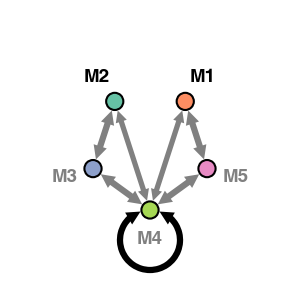

In [118]:
save = True

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets_schematic, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest_schematic]]),
                                        input_node_values=np.array([0,0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.4, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap=Set2_swapped_doublebandpass, # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
)
 
fig.set_dpi(150)

if save:
    filename = f'Fig3C_{m}M_{meta_name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

### Plot the accesssory expression levels:

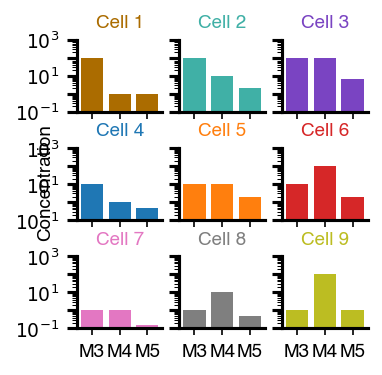

In [68]:
save = True

fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(2.5,2.5),sharex=True,sharey=True,gridspec_kw={'hspace':0.5})

paramset_cmap = paramset_cmap10.copy()

for A_i,A_key in enumerate(A_sets.keys()):
    A = np.array(list(A_sets[A_key].values()))
    row_id = A_i//3
    col_id = A_i%3
    _ = axs[row_id,col_id].bar(list(range(m-num_inputs)),A,width=0.8,color=paramset_cmap(A_i))

    _ = axs[row_id,col_id].set_title(f'Cell {A_key}',color=paramset_cmap(A_i))

    _ = axs[row_id,col_id].set_xticks(list(range(m-num_inputs)))
    _ = axs[row_id,col_id].set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = axs[row_id,col_id].set_yscale('log')
    _ = axs[row_id,col_id].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    _ = axs[row_id,col_id].set_ylim([1e-1,1e3])

    # Set yticks
    set_simple_log_ticks(axs[row_id,col_id],which='y',log_lowerbound=-1,log_upperbound=3,max_labels=4)

    # Customize spines
    axs[row_id,col_id].spines.right.set_visible(False)
    axs[row_id,col_id].spines.top.set_visible(False)
    set_spine_linewidth(axs[row_id,col_id],1)

    # Customize the major ticks
    axs[row_id,col_id].tick_params(axis='y', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row_id,col_id].tick_params(axis='y', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

    axs[row_id,col_id].spines.right.set_visible(False)
    axs[row_id,col_id].spines.top.set_visible(False)

_ = fig.supylabel('Concentration',fontsize=9)

fig.set_dpi(150)

if save:
    filename = f'Fig3C_{m}M_{meta_name}_accessory_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot the responses:

In [84]:
double_bandpass_stack_params = np.hstack((np.tile(K,reps=(len(A_sets.values())*1,1)),\
                                         np.tile(np.array([np.array(list(A.values())) for A in list(A_sets.values())]),reps=(1,1))))

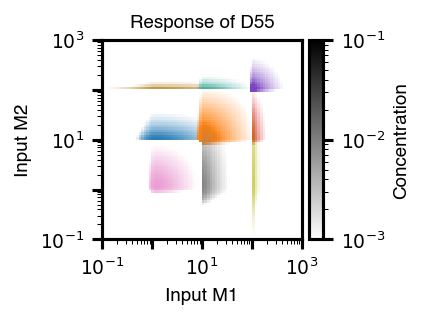

In [114]:
save = True
out_range = [1e-3,1e-1]

t=80
input_lb = -1
input_ub = 3

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(1.9,1.8))

paramset_cmap = paramset_cmap10.copy()

for A_i,A in enumerate(A_sets.keys()):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(double_bandpass_stack_params[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)

    # Make colormap varying alpha (transparency)
    base_color = paramset_cmap(A_i)
    color_array = np.tile(np.array(base_color),reps=(256,1))
    color_array[:,-1] = np.linspace(0,1,256) # Change alpha values
    map_object = mcolors.LinearSegmentedColormap.from_list(name=f'cmap_{A_i}',colors=color_array)

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    # Need to take transpose so that M1 appears on X-axis
    matrix = ax.pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                                cmap = map_object,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                        shading = 'nearest',rasterized=True)

ax.xaxis.set_ticks_position("bottom")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'Input M1')
ax.set_ylabel(f'Input M2')
ax.set_xlim([1e-1,1e3])
ax.set_ylim([1e-1,1e3])
ax.set_aspect(1) # Ensure that plot area is a perfect square
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-1,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-1,log_upperbound=3,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = ax.set_title('Response of {}'.format(make_nXn_species_names(m=m)[m+dimer_of_interest].replace('_','')))

# "Color" bar
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="7%", pad=0.05)

base_color = (0,0,0,1)
color_array = np.tile(np.array(base_color),reps=(256,1)).astype(float)
color_array[:,-1] = np.linspace(0,1,256) # Change alpha values
map_object = mcolors.LinearSegmentedColormap.from_list(name=f'alpha_black_cmap',colors=color_array)

colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]), cmap=map_object),cax=cax1,label='Concentration')
colorbar.outline.set_linewidth(1.5)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=-3,log_upperbound=-1,max_labels=4)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

fig.set_dpi(150)

if save:
    filename = f'Fig3C_{m}M_{meta_name}_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

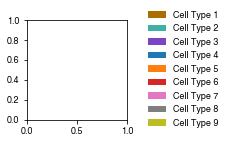

In [87]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(1.8,1.8))

patches={}
for A_i,A in enumerate(A_sets.keys()):
    patches[f'Cell Type {A}'] = mpatches.Patch(facecolor=paramset_cmap(A_i),linewidth=0,linestyle='',\
                                                alpha=1,label=f'Cell Type {A}',edgecolor=None)

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'Fig3C_palette'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 3D

2D Change-of-Function Versatility

### Define Parameter Sets

In [15]:
num_inputs = 2
m=8

t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range, in log space
input_ub = 3 # Upper bound of input range, in log space

In [16]:
param_sets_versatile = {
    'AND': np.array([3.498075148416207e-07, 0.015437538367627238, 55.93748776174965, 8.123560353793627e-08, 40373.27452742477, 5.763513705814547e-05, 3.972447498136689e-06, 0.0014097645979219834, 5.583117691693293e-07, 1.6401857689623868e-07, 0.3471065773828569, 1.509930171765406e-10, 6813.106630721027, 464.19988977949765, 6355.733068102544, 461.1532941413093, 6472419.470571058, 0.8568877488790319, 3.121029967889442e-10, 74777.62538576194, 1137.3041221476556, 88.06509759250979, 0.0003820490872727311, 7.983952087137184e-09, 496122.28966646764, 1919317.6522195244, 50.08544343391498, 2.874081151705891, 0.0018554065155359047, 1332.741172282241, 32.80825632042195, 3294.5885350537596, 85.69274002228914, 1.0517298680379826e-07, 1.1450660453049733e-05, 1.2717294480392136e-10,\
                     0.04567238738528103, 0.0010553707991341511, 0.5894034339363132, 0.0033079595213309633, 1.4165002772725621, 0.005160717191539123]),
    'ANOTB': np.array([3.498075148416207e-07, 0.015437538367627238, 55.93748776174965, 8.123560353793627e-08, 40373.27452742477, 5.763513705814547e-05, 3.972447498136689e-06, 0.0014097645979219834, 5.583117691693293e-07, 1.6401857689623868e-07, 0.3471065773828569, 1.509930171765406e-10, 6813.106630721027, 464.19988977949765, 6355.733068102544, 461.1532941413093, 6472419.470571058, 0.8568877488790319, 3.121029967889442e-10, 74777.62538576194, 1137.3041221476556, 88.06509759250979, 0.0003820490872727311, 7.983952087137184e-09, 496122.28966646764, 1919317.6522195244, 50.08544343391498, 2.874081151705891, 0.0018554065155359047, 1332.741172282241, 32.80825632042195, 3294.5885350537596, 85.69274002228914, 1.0517298680379826e-07, 1.1450660453049733e-05, 1.2717294480392136e-10,\
                     0.04683967897512681, 1.3691532916842408, 0.4526258451042632, 0.7172110763700398, 0.001012059803379696, 1.586735792306094])
}

dimer_of_interest = make_nXn_species_names(m).index('D_1_3') - m # Index of dimer to use as output (D_1_1 = index 0)

meta_name = 'AND-ANOTB-versatile'
names_to_plot = list(param_sets_versatile.keys())

In [17]:
param_sets_versatile = {
    'OR': np.array([1295.5403254428136, 2.2531138598627364e-10, 6.630449536166568e-07, 0.029827661726632194, 5.915888687046038, 2.328459566852171e-07, 849.2237029289258, 536.618947535119, 7.496943219031402e-08, 1.1671334808338533e-10, 1613195.0670308894, 3.175242076483566e-09, 0.05096458328861231, 6524.636902319715, 44.783384500546404, 4884.2101989431, 0.052887145028798196, 400092.1982029358, 0.07379069328582201, 279918.0949230118, 28.858347329177242, 3.177156691656071, 9.159951177804709e-06, 11.395990875412632, 1.6506774099866444, 0.00022222500307180246, 2.5878740523472894, 140.53623605451975, 0.16720692349262006, 186.1402943493676, 2.6730895789049776e-05, 3.449919310846131e-09, 0.0032446209288088937, 1.2939007446794935e-05, 0.0023891195750679545, 2.6115046846061285e-08,\
                     0.004412255820177712, 0.013751340367901084, 0.7286746302243393, 0.0021968305130597885, 0.6301591842374938, 0.9608357183162661]),
    'NOR': np.array([1295.5403254428136, 2.2531138598627364e-10, 6.630449536166568e-07, 0.029827661726632194, 5.915888687046038, 2.328459566852171e-07, 849.2237029289258, 536.618947535119, 7.496943219031402e-08, 1.1671334808338533e-10, 1613195.0670308894, 3.175242076483566e-09, 0.05096458328861231, 6524.636902319715, 44.783384500546404, 4884.2101989431, 0.052887145028798196, 400092.1982029358, 0.07379069328582201, 279918.0949230118, 28.858347329177242, 3.177156691656071, 9.159951177804709e-06, 11.395990875412632, 1.6506774099866444, 0.00022222500307180246, 2.5878740523472894, 140.53623605451975, 0.16720692349262006, 186.1402943493676, 2.6730895789049776e-05, 3.449919310846131e-09, 0.0032446209288088937, 1.2939007446794935e-05, 0.0023891195750679545, 2.6115046846061285e-08,\
                     2.118301261210358, 0.0011944161249180386, 1.1362789056514102, 0.005097544131535074, 2.2003451834893175, 0.13427699753759126])
}

dimer_of_interest = make_nXn_species_names(m).index('D_5_5') - m # Index of dimer to use as output (D_1_1 = index 0)

meta_name = 'OR-NOR-versatile'
names_to_plot = list(param_sets_versatile.keys())

In [18]:
param_sets_versatile = {
    'AND': np.array([2090711.7340542946, 77.93003102590879, 0.0001373909154808613, 8704570.08801963, 2.387253960083264e-05, 377.8303438891092, 5.509904814225678e-07, 9948187.786299827, 2.0953561785167248e-08, 0.00016945360104140923, 200641.75545522763, 0.12021605341283592, 115.89816609575969, 2.8107862516174277e-05, 0.00033702349078989, 1050121.724619351, 2.8119641227686927, 7.423613019635448e-07, 8.276241994219246, 5.3689111480968075, 0.3543193122755227, 0.12290646446467716, 763.074336138846, 5281.14497432884, 3142451.088497419, 154386.4790663943, 0.031225331935647492, 22477.22070077433, 155110.637452671, 21244.78511128135, 0.018303821523661647, 36.64887329672761, 0.16730846089364274, 1.592993593241493e-05, 26.34581050618525, 1.5995359428332983e-06,\
                     993.4250190210124, 0.007208355454003877, 0.002943282875733605, 2.0141724598483495, 0.3431881814917819, 1.7071574687399271]),
    'NOR': np.array([2090711.7340542946, 77.93003102590879, 0.0001373909154808613, 8704570.08801963, 2.387253960083264e-05, 377.8303438891092, 5.509904814225678e-07, 9948187.786299827, 2.0953561785167248e-08, 0.00016945360104140923, 200641.75545522763, 0.12021605341283592, 115.89816609575969, 2.8107862516174277e-05, 0.00033702349078989, 1050121.724619351, 2.8119641227686927, 7.423613019635448e-07, 8.276241994219246, 5.3689111480968075, 0.3543193122755227, 0.12290646446467716, 763.074336138846, 5281.14497432884, 3142451.088497419, 154386.4790663943, 0.031225331935647492, 22477.22070077433, 155110.637452671, 21244.78511128135, 0.018303821523661647, 36.64887329672761, 0.16730846089364274, 1.592993593241493e-05, 26.34581050618525, 1.5995359428332983e-06,\
                     865.3938421008049, 0.0057685806752670885, 227.58679296659412, 12.500904018261702, 166.1671981613064, 51.44451040338165])
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_7') - m # Index of dimer to use as output (D_1_1 = index 0)

meta_name = 'AND-NOR-versatile'
names_to_plot = list(param_sets_versatile.keys())

### Plot the schematics:

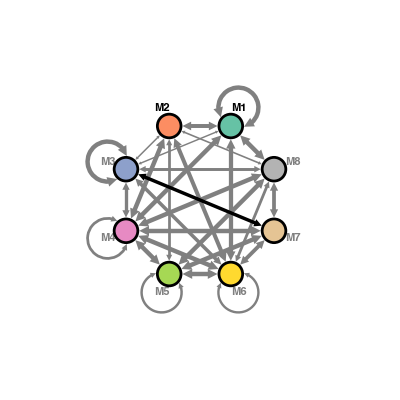

In [39]:
save = True

K = param_sets_versatile[names_to_plot[0]][:-(m-num_inputs)]

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0), # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]),
                                        input_node_values=np.array([0,0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.4, # Radius of nodes around center
                                        r_loop = 0.175, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.5,2], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,                                       
) 

fig.set_dpi(150)

if save:
    filename = f'Fig3D_{m}M_{meta_name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

### Plot the accesssory expression levels:

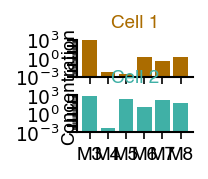

In [62]:
save = True

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(1.75,1.75),sharex=True,sharey=True,gridspec_kw={'hspace':0.5})

paramset_cmap = triple_cmap.copy()

for name_i, name in enumerate(names_to_plot):
    A = np.array(param_sets_versatile[name][-(m-num_inputs):])
    
    _ = axs[name_i].bar(list(range(m-num_inputs)),A,width=0.8,color=paramset_cmap(name_i))
    _ = axs[name_i].set_title(f'Cell {name_i+1}',color=paramset_cmap(name_i))

    _ = axs[name_i].set_xticks(list(range(m-num_inputs)))
    _ = axs[name_i].set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = axs[name_i].set_yscale('log')
    _ = axs[name_i].set_yticks([1e-3,1e-1,1e1,1e3])
    _ = axs[name_i].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    _ = axs[name_i].set_ylim([1e-3,1e3])

    # Set yticks
    set_simple_log_ticks(axs[name_i],which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

    # Customize spines
    axs[name_i].spines.right.set_visible(False)
    axs[name_i].spines.top.set_visible(False)
    set_spine_linewidth(axs[name_i],1)

    # Customize the major ticks
    axs[name_i].tick_params(axis='y', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[name_i].tick_params(axis='y', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks


_ = fig.supylabel('Concentration',fontsize=9)

fig.set_dpi(150)

if save:
    filename = f'Fig3D_{m}M_{meta_name}_accessory_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot the responses:

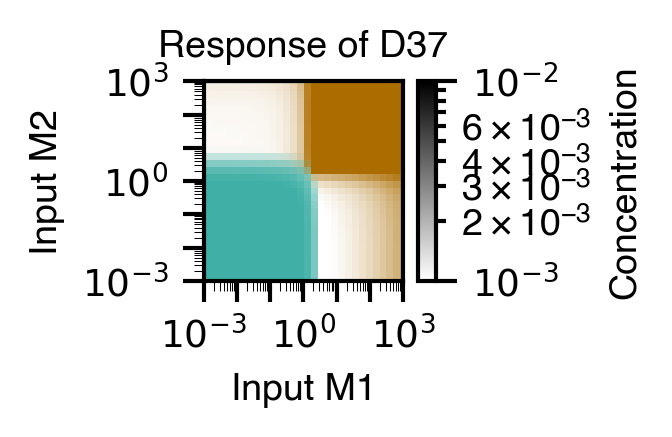

In [59]:
save = True

out_range=[1e-3,1e-2]

t=30
input_lb = -3
input_ub = 3

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(1.9,1.8))

paramset_cmap = triple_cmap.copy()

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

for name_i,name in enumerate(names_to_plot):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(param_sets_versatile[name],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Make colormap varying alpha (transparency)
    base_color = paramset_cmap(name_i)
    color_array = np.tile(np.array(base_color),reps=(256,1))
    color_array[:,-1] = np.linspace(0,1,256) # Change alpha values
    map_object = mcolors.LinearSegmentedColormap.from_list(name=f'cmap_{name_i}',colors=color_array)

    # Need to take transpose so that M1 appears on X-axis
    matrix = ax.pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = map_object,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)

ax.xaxis.set_ticks_position("bottom")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'Input M1')
ax.set_ylabel(f'Input M2')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim([10**input_lb,10**input_ub])
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.set_aspect(1) # Ensure that plot area is a perfect square

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-3,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

# _ = ax.set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
_ = ax.set_title('Response of {}'.format(make_nXn_species_names(m=m)[m+dimer_of_interest].replace('_','')))

# "Color" bar
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="9%", pad=0.05)

base_color = (0,0,0,1)
color_array = np.tile(np.array(base_color),reps=(256,1)).astype(float)
color_array[:,-1] = np.linspace(0,1,256) # Change alpha values
map_object = mcolors.LinearSegmentedColormap.from_list(name=f'alpha_black_cmap',colors=color_array)

colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]), cmap=map_object),cax=cax1,label='Concentration')
colorbar.outline.set_linewidth(1)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=-3,log_upperbound=-2,max_labels=2)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

fig.set_dpi(150)

if save:
    filename = f'Fig3D_{m}M_{meta_name}_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True,dpi=1200)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Movies - 2D Versatility

### Tunable 2D Bandpass Filter

In [57]:
m=5
meta_name = 'tunable_2D_bandpass' 
K = np.array([1e-10, 1e-10, 1e-10, 10000.0, 20.0, 1e-10, 10000.0, 1e-10, 20.0, 1e-10, 1e-10, 10000.0, 1e-10, 10000.0, 1000.0])
dimer_of_interest = 14

num_inputs = 2

In [58]:
A_sets = [
    {
    'M3': 1e0,
    'M4': 1e0,
    'M5': 1.5e-1,
    },
    {
    'M3': 1e1,
    'M4': 1e0,
    'M5': 5e-1,
    },
    {
    'M3': 1e2,
    'M4': 1e0,
    'M5': 1.5e0, # Formerly 1e0
    },
    {
    'M3': 1e2,
    'M4': 1e1,
    'M5': 2e0,
    },
    {
    'M3': 1e2,
    'M4': 1e2,
    'M5': 7e0,
    },
    {
    'M3': 1e1,
    'M4': 1e2,
    'M5': 2e0,
    },
    {
    'M3': 1e0,
    'M4': 1e2,
    'M5': 1.5e0, # Formerly 1e0
    },
    {
    'M3': 1e0,
    'M4': 1e1,
    'M5': 5e-1,
    },
    {
    'M3': 1e0,
    'M4': 1e0,
    'M5': 1.5e-1,
    },
    {
    'M3': 1e1,
    'M4': 1e1,
    'M5': 2e0,
    },
    {
    'M3': 1e2,
    'M4': 1e2,
    'M5': 7e0,
    },
    {
    'M3': 1e1,
    'M4': 1e1,
    'M5': 2e0,
    },
    {
    'M3': 1e0,
    'M4': 1e0,
    'M5': 1.5e-1,
    },
]

#### First plot the manually defined parameter sets:

In [59]:
movie_param_sets = np.hstack((np.tile(K,reps=(len(A_sets)*1,1)),\
                                         np.tile(np.array([np.array(list(A.values())) for A in A_sets]),reps=(1,1))))

  0% (0 of 13) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  7% (1 of 13) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:10
 15% (2 of 13) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:09
 23% (3 of 13) |#####                    | Elapsed Time: 0:00:02 ETA:   0:00:08
 30% (4 of 13) |#######                  | Elapsed Time: 0:00:03 ETA:   0:00:06
 38% (5 of 13) |#########                | Elapsed Time: 0:00:03 ETA:   0:00:05
 46% (6 of 13) |###########              | Elapsed Time: 0:00:04 ETA:   0:00:04
 53% (7 of 13) |#############            | Elapsed Time: 0:00:04 ETA:   0:00:03
 61% (8 of 13) |###############          | Elapsed Time: 0:00:05 ETA:   0:00:03
 69% (9 of 13) |#################        | Elapsed Time: 0:00:06 ETA:   0:00:02
 76% (10 of 13) |##################      | Elapsed Time: 0:00:07 ETA:   0:00:02
 84% (11 of 13) |####################    | Elapsed Time: 0:00:07 ETA:   0:00:01
 92% (12 of 13) |######################  | Elapsed Time: 0:00:08 ETA:   0:00:00
100% (13 of 13) |#######################

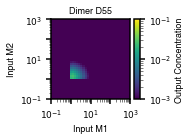

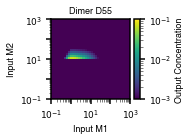

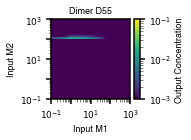

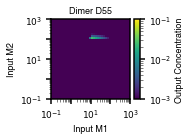

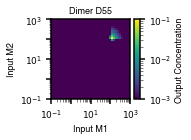

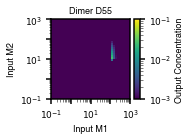

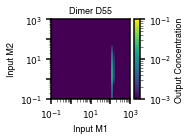

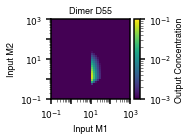

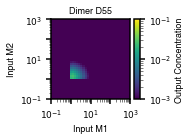

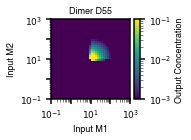

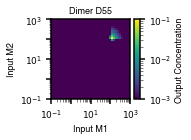

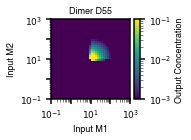

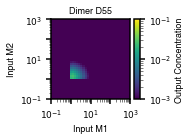

In [28]:
save = False
out_range = [1e-3,1e-1]

t=40
input_lb = -1
input_ub = 3

for A_i in progressbar.progressbar(range(len(A_sets))):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(1.6,1.5))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')
    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    # fig.set_dpi(300)

#### Then, we interpolate between these points

In [60]:
num_defined_A_sets = len(A_sets)
num_interpolate_points = 10 # Number of parameter sets to simulate for each defined A set
num_A_sets = num_defined_A_sets*num_interpolate_points
movie_param_sets = np.hstack((np.tile(K,reps=(num_defined_A_sets*num_interpolate_points,1)),\
                                         np.tile(np.array([np.array(list(A.values())) for A in A_sets]),reps=(num_interpolate_points,1))))
for A_i in range(num_defined_A_sets):
    A = np.log10(np.array(list(A_sets[A_i].values())))
    if A_i==num_defined_A_sets-1:
        A_next = np.log10(np.array(list(A_sets[0].values())))
    else:
        A_next = np.log10(np.array(list(A_sets[A_i+1].values())))
    interpolated_vals = np.array([10**np.interp(np.arange(num_interpolate_points),np.array([0,num_interpolate_points]),\
                               np.array([A[acc],A_next[acc]]))\
                             for acc in range(m-2)]).T
    movie_param_sets[A_i*num_interpolate_points:(A_i+1)*num_interpolate_points,-(m-2):] = interpolated_vals

Plot the responses:

In [61]:
out_range = [1e-3,1e-1]

t=40
input_lb = -1
input_ub = 3

for A_i in progressbar.progressbar(range(num_A_sets)):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2.15,2))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
    
    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')

    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses'))):
        os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses')))
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                    f'{meta_name}_movie_responses_{A_i}.tiff')),\
                                dpi=300,bbox_inches='tight')
    plt.close()

  0% (0 of 130) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 130) |                        | Elapsed Time: 0:00:01 ETA:   0:02:31
  1% (2 of 130) |                        | Elapsed Time: 0:00:03 ETA:   0:05:17
  2% (3 of 130) |                        | Elapsed Time: 0:00:06 ETA:   0:05:33
  3% (4 of 130) |                        | Elapsed Time: 0:00:10 ETA:   0:08:45
  3% (5 of 130) |                        | Elapsed Time: 0:00:12 ETA:   0:04:46
  4% (6 of 130) |#                       | Elapsed Time: 0:00:14 ETA:   0:04:07
  5% (7 of 130) |#                       | Elapsed Time: 0:00:16 ETA:   0:04:45
  6% (8 of 130) |#                       | Elapsed Time: 0:00:19 ETA:   0:04:54
  6% (9 of 130) |#                       | Elapsed Time: 0:00:22 ETA:   0:05:51
  7% (10 of 130) |#                      | Elapsed Time: 0:00:24 ETA:   0:05:17
  8% (11 of 130) |#                      | Elapsed Time: 0:00:27 ETA:   0:05:46
  9% (12 of 130) |##                    

Then make bar plots of the accessory expression levels:

In [39]:
for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, ax = plt.subplots(figsize=(1.5,2))
    _ = ax.bar(list(range(m-num_inputs)),A,width=0.8,color='gray')

    _ = ax.set_xticks(list(range(m-num_inputs)))
    _ = ax.set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = ax.set_yscale('log')
    _ = ax.set_ylim([1e-1,1e3])
    
    # Set ticks
    set_simple_log_ticks(ax,which='y',log_lowerbound=-1,log_upperbound=3,max_labels=4)

    # Customize spines
    set_spine_linewidth(ax,1.5)

    # Customize the major ticks
    ax.tick_params(axis='y', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    _ = ax.set_ylabel('Concentration')
    _ = ax.set_title('Accessory Proteins')

    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                 f'{meta_name}_movie_concs_{A_i}.tiff')),dpi=300,bbox_inches='tight')
    plt.close()

  0% (0 of 130) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  0% (1 of 130) |                        | Elapsed Time: 0:00:00 ETA:   0:01:28
  1% (2 of 130) |                        | Elapsed Time: 0:00:01 ETA:   0:01:16
  2% (3 of 130) |                        | Elapsed Time: 0:00:01 ETA:   0:01:06
  3% (4 of 130) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09
  3% (5 of 130) |                        | Elapsed Time: 0:00:02 ETA:   0:01:02
  4% (6 of 130) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:00
  5% (7 of 130) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56
  6% (8 of 130) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57
  6% (9 of 130) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:49
  7% (10 of 130) |#                      | Elapsed Time: 0:00:04 ETA:   0:00:48
  8% (11 of 130) |#                      | Elapsed Time: 0:00:05 ETA:   0:00:46
  9% (12 of 130) |##                     | Elapsed Time: 0:00:05 ETA:   0:01:01
 10% (13 of 130) |##                    

and plot schematics for all the parameter sets (will need to be down-scaled in post):

In [43]:
num_A_sets

130

In [51]:
for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, axs = make_network_plots_polygon(m=m, \
                                        n_input=num_inputs,\
                                        param_sets=np.expand_dims(np.hstack((K,A)),axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        dimers_of_interest=np.array([[dimer_of_interest]]),\
                                        r_node = 0.6, \
                                        r_loop = 0.3,\
                                        node_scales = [-1,1,5,20], \
                                        input_node_values=np.zeros(num_inputs),\
                                        K_edge_scales = [-4,3,1,3],\
                                        input_cmap='Set2',\
                                        fontname='Helvetica',\
                                        fontsize=14,\
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        non_output_dimer_color='gray')
    
    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                 f'{meta_name}_movie_schematics_{A_i}.tiff')),dpi=300,bbox_inches='tight')
    plt.close()

  0% (0 of 130) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  0% (1 of 130) |                        | Elapsed Time: 0:00:00 ETA:   0:00:34
  1% (2 of 130) |                        | Elapsed Time: 0:00:00 ETA:   0:00:35
  2% (3 of 130) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32
  3% (4 of 130) |                        | Elapsed Time: 0:00:04 ETA:   0:08:00
  3% (5 of 130) |                        | Elapsed Time: 0:00:04 ETA:   0:04:15
  4% (6 of 130) |#                       | Elapsed Time: 0:00:05 ETA:   0:02:57
  5% (7 of 130) |#                       | Elapsed Time: 0:00:05 ETA:   0:02:18
  6% (8 of 130) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:54
  6% (9 of 130) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:38
  7% (10 of 130) |#                      | Elapsed Time: 0:00:05 ETA:   0:01:27
  8% (11 of 130) |#                      | Elapsed Time: 0:00:06 ETA:   0:01:18
  9% (12 of 130) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:11
 10% (13 of 130) |##                    

### Versatile AND/NOR

In [145]:
m = 8
K = np.array([2090711.7340542946, 77.93003102590879, 0.0001373909154808613, 8704570.08801963, 2.387253960083264e-05, 377.8303438891092, 5.509904814225678e-07, 9948187.786299827, 2.0953561785167248e-08, 0.00016945360104140923, 200641.75545522763, 0.12021605341283592, 115.89816609575969, 2.8107862516174277e-05, 0.00033702349078989, 1050121.724619351, 2.8119641227686927, 7.423613019635448e-07, 8.276241994219246, 5.3689111480968075, 0.3543193122755227, 0.12290646446467716, 763.074336138846, 5281.14497432884, 3142451.088497419, 154386.4790663943, 0.031225331935647492, 22477.22070077433, 155110.637452671, 21244.78511128135, 0.018303821523661647, 36.64887329672761, 0.16730846089364274, 1.592993593241493e-05, 26.34581050618525, 1.5995359428332983e-06])

dimer_of_interest = 19

num_inputs = 2

meta_name = '2D-AND-NOR'

# Pause briefly on each "manually defined" parameter set after transitioning between them
number_pause_frames = 10 # Number of frames to pause 

In [146]:
A_sets = np.array([
    [993.4250190210124, 0.007208355454003877, 0.002943282875733605, 2.0141724598483495, 0.3431881814917819, 1.7071574687399271],
    [865.3938421008049, 0.0057685806752670885, 227.58679296659412, 12.500904018261702, 166.1671981613064, 51.44451040338165]
])

#### First plot the manually defined parameter sets:

In [147]:
movie_param_sets = np.hstack((np.tile(K,reps=(A_sets.shape[0]*1,1)),\
                                         np.tile(A_sets,reps=(1,1))))

  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


 50% (1 of 2) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


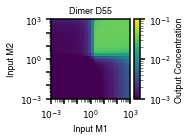

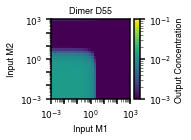

In [55]:
save = False
out_range = [1e-3,1e-1]

t=30
input_lb = -3
input_ub = 3

for A_i in progressbar.progressbar(range(len(A_sets))):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(1.6,1.5))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')
    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

#### Then, we interpolate between these points

In [148]:
num_defined_A_sets = A_sets.shape[0]
num_interpolate_points = 40 # Number of parameter sets to simulate for each defined A set
num_A_sets = num_defined_A_sets*num_interpolate_points
movie_param_sets = np.hstack((np.tile(K,reps=(num_defined_A_sets*num_interpolate_points,1)),\
                                         np.tile(A_sets,reps=(num_interpolate_points,1))))
for A_i in range(num_defined_A_sets):
    A = np.log10(A_sets[A_i])
    if A_i==num_defined_A_sets-1:
        A_next = np.log10(A_sets[0])
    else:
        A_next = np.log10(A_sets[A_i+1])
    interpolated_vals = np.array([10**np.interp(np.arange(num_interpolate_points),np.array([0,num_interpolate_points]),\
                               np.array([A[acc],A_next[acc]]))\
                             for acc in range(m-2)]).T
    movie_param_sets[A_i*num_interpolate_points:(A_i+1)*num_interpolate_points,-(m-2):] = interpolated_vals

Plot the responses:

In [129]:
save = True
out_range = [1e-3,1e-1]

t=30
input_lb = -3
input_ub = 3

counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)

for A_i in progressbar.progressbar(range(num_A_sets)):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2.15,2))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
    
    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')

    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    if save:
        if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses')))
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                     f'{meta_name}_movie_responses_{counter}.tiff')),\
                                    dpi=300,bbox_inches='tight')
        counter+=1
        if A_i%num_interpolate_points==0:
            if A_i==0:
                for extra_i in range(number_pause_frames):
                    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                            f'{meta_name}_movie_responses_{counter_extra_pause_frames}.tiff')),\
                                            dpi=300,bbox_inches='tight')
                    counter_extra_pause_frames+=1
                plt.close()
            else:
                for extra_i in range(number_pause_frames):
                    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                            f'{meta_name}_movie_responses_{counter}.tiff')),\
                                            dpi=300,bbox_inches='tight')
                    counter+=1
                plt.close()
        else:
            plt.close()

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 80) |                         | Elapsed Time: 0:00:11 ETA:   0:15:34
  2% (2 of 80) |                         | Elapsed Time: 0:00:13 ETA:   0:08:45
  3% (3 of 80) |                         | Elapsed Time: 0:00:15 ETA:   0:02:08
  5% (4 of 80) |#                        | Elapsed Time: 0:00:17 ETA:   0:02:14
  6% (5 of 80) |#                        | Elapsed Time: 0:00:18 ETA:   0:02:14
  7% (6 of 80) |#                        | Elapsed Time: 0:00:20 ETA:   0:02:14
  8% (7 of 80) |##                       | Elapsed Time: 0:00:22 ETA:   0:02:12
 10% (8 of 80) |##                       | Elapsed Time: 0:00:24 ETA:   0:02:30
 11% (9 of 80) |##                       | Elapsed Time: 0:00:26 ETA:   0:02:18
 12% (10 of 80) |###                     | Elapsed Time: 0:00:27 ETA:   0:02:02
 13% (11 of 80) |###                     | Elapsed Time: 0:00:30 ETA:   0:02:54
 15% (12 of 80) |###                    

Then make bar plots of the accessory expression levels:

In [149]:
counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)

for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, ax = plt.subplots(figsize=(2.5,2))
    _ = ax.bar(list(range(m-num_inputs)),A,width=0.8,color='gray')

    _ = ax.set_xticks(list(range(m-num_inputs)))
    _ = ax.set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = ax.set_yscale('log')
    _ = ax.set_ylim([1e-3,1e3])
    
    # Set ticks
    set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

    # Customize spines
    set_spine_linewidth(ax,1.5)

    # Customize the major ticks
    ax.tick_params(axis='y', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    _ = ax.set_ylabel('Concentration')
    _ = ax.set_title('Accessory Proteins')

    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                 f'{meta_name}_movie_concs_{counter}.tiff')),dpi=300,bbox_inches='tight')
    counter+=1
    if A_i%num_interpolate_points==0:
        if A_i==0:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                                f'{meta_name}_movie_concs_{counter_extra_pause_frames}.tiff')),dpi=300,bbox_inches='tight')
                print(counter_extra_pause_frames)
                counter_extra_pause_frames+=1
                
            plt.close()
        else:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                                f'{meta_name}_movie_concs_{counter}.tiff')),dpi=300,bbox_inches='tight')
                print(counter)
                counter+=1
            plt.close()
    else:    
        plt.close()

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


90
91
92
93
94
95
96
97
98


  1% (1 of 80) |                         | Elapsed Time: 0:00:05 ETA:   0:07:08


99


  2% (2 of 80) |                         | Elapsed Time: 0:00:05 ETA:   0:03:53
  3% (3 of 80) |                         | Elapsed Time: 0:00:06 ETA:   0:02:51
  5% (4 of 80) |#                        | Elapsed Time: 0:00:07 ETA:   0:00:52
  6% (5 of 80) |#                        | Elapsed Time: 0:00:08 ETA:   0:00:52
  7% (6 of 80) |#                        | Elapsed Time: 0:00:08 ETA:   0:00:50
  8% (7 of 80) |##                       | Elapsed Time: 0:00:09 ETA:   0:00:51
 10% (8 of 80) |##                       | Elapsed Time: 0:00:10 ETA:   0:00:50
 11% (9 of 80) |##                       | Elapsed Time: 0:00:10 ETA:   0:00:52
 12% (10 of 80) |###                     | Elapsed Time: 0:00:11 ETA:   0:00:48
 13% (11 of 80) |###                     | Elapsed Time: 0:00:12 ETA:   0:00:50
 15% (12 of 80) |###                     | Elapsed Time: 0:00:13 ETA:   0:00:57
 16% (13 of 80) |###                     | Elapsed Time: 0:00:14 ETA:   0:01:01
 17% (14 of 80) |####                   

41
42
43
44
45
46
47
48
49


 51% (41 of 80) |############            | Elapsed Time: 0:00:53 ETA:   0:03:44


50


 52% (42 of 80) |############            | Elapsed Time: 0:00:53 ETA:   0:02:01
 53% (43 of 80) |############            | Elapsed Time: 0:00:54 ETA:   0:01:24
 55% (44 of 80) |#############           | Elapsed Time: 0:00:54 ETA:   0:01:06
 56% (45 of 80) |#############           | Elapsed Time: 0:00:55 ETA:   0:00:18
 57% (46 of 80) |#############           | Elapsed Time: 0:00:55 ETA:   0:00:17
 58% (47 of 80) |##############          | Elapsed Time: 0:00:56 ETA:   0:00:16
 60% (48 of 80) |##############          | Elapsed Time: 0:00:56 ETA:   0:00:16
 61% (49 of 80) |##############          | Elapsed Time: 0:00:57 ETA:   0:00:15
 62% (50 of 80) |###############         | Elapsed Time: 0:00:57 ETA:   0:00:14
 63% (51 of 80) |###############         | Elapsed Time: 0:00:58 ETA:   0:00:13
 65% (52 of 80) |###############         | Elapsed Time: 0:00:58 ETA:   0:00:13
 66% (53 of 80) |###############         | Elapsed Time: 0:00:59 ETA:   0:00:12
 67% (54 of 80) |################       

and plot schematics for all the parameter sets (will need to be down-scaled in post):

In [150]:
counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)
for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, axs = make_network_plots_polygon(m=m, \
                                        n_input=num_inputs,\
                                        param_sets=np.expand_dims(np.hstack((K,A)),axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        dimers_of_interest=np.array([[dimer_of_interest]]),\
                                        r_node = 0.6, \
                                        r_loop = 0.3,\
                                        node_scales = [-3,3,5,20], \
                                        input_node_values=np.zeros(num_inputs),\
                                        K_edge_scales = [-4,3,1,3],\
                                        input_cmap='Set2',\
                                        fontname='Helvetica',\
                                        fontsize=14,\
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        non_output_dimer_color='gray')
    
    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                 f'{meta_name}_movie_schematics_{counter}.tiff')),dpi=300,bbox_inches='tight')
    counter+=1
    if A_i%num_interpolate_points==0:
        if A_i==0:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                                            f'{meta_name}_movie_schematics_{counter_extra_pause_frames}.tiff')),dpi=300,bbox_inches='tight')
                counter_extra_pause_frames+=1
            plt.close()
        else:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                                            f'{meta_name}_movie_schematics_{counter}.tiff')),dpi=300,bbox_inches='tight')
                counter+=1
            plt.close()
    else:
        plt.close()
        pass

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 80) |                         | Elapsed Time: 0:00:01 ETA:   0:01:58
  2% (2 of 80) |                         | Elapsed Time: 0:00:02 ETA:   0:01:19
  3% (3 of 80) |                         | Elapsed Time: 0:00:02 ETA:   0:01:06
  5% (4 of 80) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:56
  6% (5 of 80) |#                        | Elapsed Time: 0:00:03 ETA:   0:00:39
  7% (6 of 80) |#                        | Elapsed Time: 0:00:04 ETA:   0:00:39
  8% (7 of 80) |##                       | Elapsed Time: 0:00:04 ETA:   0:00:39
 10% (8 of 80) |##                       | Elapsed Time: 0:00:05 ETA:   0:00:43
 11% (9 of 80) |##                       | Elapsed Time: 0:00:05 ETA:   0:00:40
 12% (10 of 80) |###                     | Elapsed Time: 0:00:06 ETA:   0:00:37
 13% (11 of 80) |###                     | Elapsed Time: 0:00:06 ETA:   0:00:35
 15% (12 of 80) |###                     | Elapsed Time: 0:00:07 ETA:   0:00:33
 16% (13 of 80) |###                    

### Versatile OR/NOR

In [157]:
m = 8
K = np.array([1295.5403254428136, 2.2531138598627364e-10, 6.630449536166568e-07, 0.029827661726632194, 5.915888687046038, 2.328459566852171e-07, 849.2237029289258, 536.618947535119, 7.496943219031402e-08, 1.1671334808338533e-10, 1613195.0670308894, 3.175242076483566e-09, 0.05096458328861231, 6524.636902319715, 44.783384500546404, 4884.2101989431, 0.052887145028798196, 400092.1982029358, 0.07379069328582201, 279918.0949230118, 28.858347329177242, 3.177156691656071, 9.159951177804709e-06, 11.395990875412632, 1.6506774099866444, 0.00022222500307180246, 2.5878740523472894, 140.53623605451975, 0.16720692349262006, 186.1402943493676, 2.6730895789049776e-05, 3.449919310846131e-09, 0.0032446209288088937, 1.2939007446794935e-05, 0.0023891195750679545, 2.6115046846061285e-08])

dimer_of_interest = 26

num_inputs = 2

meta_name = '2D-OR-NOR'

# Pause briefly on each "manually defined" parameter set after transitioning between them
number_pause_frames = 10 # Number of frames to pause 

In [158]:
A_sets = np.array([
    [0.004412255820177712, 0.013751340367901084, 0.7286746302243393, 0.0021968305130597885, 0.6301591842374938, 0.9608357183162661],
    [2.118301261210358, 0.0011944161249180386, 1.1362789056514102, 0.005097544131535074, 2.2003451834893175, 0.13427699753759126],
])

#### First plot the manually defined parameter sets:

In [159]:
movie_param_sets = np.hstack((np.tile(K,reps=(A_sets.shape[0]*1,1)),\
                                         np.tile(A_sets,reps=(1,1))))

  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


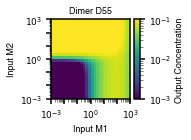

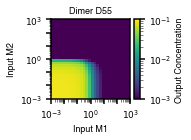

In [86]:
save = False
out_range = [1e-3,1e-1]

t=30
input_lb = -3
input_ub = 3

for A_i in progressbar.progressbar(range(len(A_sets))):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(1.6,1.5))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')
    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

#### Then, we interpolate between these points

In [160]:
num_defined_A_sets = A_sets.shape[0]
num_interpolate_points = 40 # Number of parameter sets to simulate for each defined A set
num_A_sets = num_defined_A_sets*num_interpolate_points
movie_param_sets = np.hstack((np.tile(K,reps=(num_defined_A_sets*num_interpolate_points,1)),\
                                         np.tile(A_sets,reps=(num_interpolate_points,1))))
for A_i in range(num_defined_A_sets):
    A = np.log10(A_sets[A_i])
    if A_i==num_defined_A_sets-1:
        A_next = np.log10(A_sets[0])
    else:
        A_next = np.log10(A_sets[A_i+1])
    interpolated_vals = np.array([10**np.interp(np.arange(num_interpolate_points),np.array([0,num_interpolate_points]),\
                               np.array([A[acc],A_next[acc]]))\
                             for acc in range(m-2)]).T
    movie_param_sets[A_i*num_interpolate_points:(A_i+1)*num_interpolate_points,-(m-2):] = interpolated_vals

Plot the responses:

In [136]:
save = True
out_range = [1e-3,1e-1]

t=30
input_lb = -3
input_ub = 3

counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)

for A_i in progressbar.progressbar(range(num_A_sets)):
    C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=np.expand_dims(movie_param_sets[A_i],axis=0), \
                                         t = t, input_lb = input_lb, input_ub = input_ub)
    # Plot a desired response
    
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2.15,2))
    axs = np.array([[axs]])

    cmap = plt.get_cmap('viridis')

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    row = 0
    col = 0
    # Need to take transpose so that M1 appears on X-axis
    matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_xlim([1e-1,1e3])
    axs[row,col].set_ylim([1e-1,1e3])
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
    
    # _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+dimer_of_interest])
    _ = axs[row,col].set_title('Dimer D55')
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="8%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Output Concentration')

    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)
    
    # Customize spines
    set_spine_linewidth(axs[row,col],1.5)
    colorbar.outline.set_linewidth(1.5)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    if save:
        if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses')))
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                     f'{meta_name}_movie_responses_{counter}.tiff')),\
                                    dpi=300,bbox_inches='tight')
        counter+=1
        # Deal with "pause" frames
        if A_i%num_interpolate_points==0:
            if A_i==0:
                for extra_i in range(number_pause_frames):
                    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                                f'{meta_name}_movie_responses_{counter_extra_pause_frames}.tiff')),\
                                                dpi=300,bbox_inches='tight')
                    counter_extra_pause_frames+=1
                plt.close()
            else:
                for extra_i in range(number_pause_frames):
                    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_responses',\
                                                f'{meta_name}_movie_responses_{counter}.tiff')),\
                                                dpi=300,bbox_inches='tight')
                    counter+=1
                plt.close()
        else:
            plt.close()

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 80) |                         | Elapsed Time: 0:00:08 ETA:   0:10:44
  2% (2 of 80) |                         | Elapsed Time: 0:00:09 ETA:   0:06:05
  3% (3 of 80) |                         | Elapsed Time: 0:00:11 ETA:   0:01:58
  5% (4 of 80) |#                        | Elapsed Time: 0:00:12 ETA:   0:01:58
  6% (5 of 80) |#                        | Elapsed Time: 0:00:13 ETA:   0:01:35
  7% (6 of 80) |#                        | Elapsed Time: 0:00:15 ETA:   0:01:34
  8% (7 of 80) |##                       | Elapsed Time: 0:00:16 ETA:   0:01:34
 10% (8 of 80) |##                       | Elapsed Time: 0:00:17 ETA:   0:01:34
 11% (9 of 80) |##                       | Elapsed Time: 0:00:18 ETA:   0:01:31
 12% (10 of 80) |###                     | Elapsed Time: 0:00:20 ETA:   0:01:27
 13% (11 of 80) |###                     | Elapsed Time: 0:00:21 ETA:   0:01:40
 15% (12 of 80) |###                     | Elapsed Time: 0:00:23 ETA:   0:01:39
 16% (13 of 80) |###                    

Then make bar plots of the accessory expression levels:

In [155]:
counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)

for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, ax = plt.subplots(figsize=(2.5,2))
    _ = ax.bar(list(range(m-num_inputs)),A,width=0.8,color='gray')

    _ = ax.set_xticks(list(range(m-num_inputs)))
    _ = ax.set_xticklabels([make_nXn_species_names(m)[x+num_inputs].replace('_','') for x in range(m-num_inputs)])

    _ = ax.set_yscale('log')
    _ = ax.set_ylim([1e-3,1e3])
    
    # Set ticks
    set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

    # Customize spines
    set_spine_linewidth(ax,1.5)

    # Customize the major ticks
    ax.tick_params(axis='y', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

    # Customize the minor ticks
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

    _ = ax.set_ylabel('Concentration')
    _ = ax.set_title('Accessory Proteins')

    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                 f'{meta_name}_movie_concs_{counter}.tiff')),dpi=300,bbox_inches='tight')
    counter+=1
    # Deal with "pause" frames
    if A_i%num_interpolate_points==0:
        if A_i==0:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                                f'{meta_name}_movie_concs_{counter_extra_pause_frames}.tiff')),dpi=300,bbox_inches='tight')
                counter_extra_pause_frames+=1
            plt.close()
        else:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_concs',\
                                                f'{meta_name}_movie_concs_{counter}.tiff')),dpi=300,bbox_inches='tight')
                counter+=1
            plt.close()
    else:
        plt.close()

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 80) |                         | Elapsed Time: 0:00:05 ETA:   0:06:55
  2% (2 of 80) |                         | Elapsed Time: 0:00:05 ETA:   0:03:44
  3% (3 of 80) |                         | Elapsed Time: 0:00:06 ETA:   0:02:44
  5% (4 of 80) |#                        | Elapsed Time: 0:00:07 ETA:   0:02:13
  6% (5 of 80) |#                        | Elapsed Time: 0:00:08 ETA:   0:01:03
  7% (6 of 80) |#                        | Elapsed Time: 0:00:09 ETA:   0:01:32
  8% (7 of 80) |##                       | Elapsed Time: 0:00:10 ETA:   0:01:30
 10% (8 of 80) |##                       | Elapsed Time: 0:00:12 ETA:   0:01:32
 11% (9 of 80) |##                       | Elapsed Time: 0:00:13 ETA:   0:01:32
 12% (10 of 80) |###                     | Elapsed Time: 0:00:14 ETA:   0:01:25
 13% (11 of 80) |###                     | Elapsed Time: 0:00:15 ETA:   0:01:26
 15% (12 of 80) |###                     | Elapsed Time: 0:00:17 ETA:   0:01:27
 16% (13 of 80) |###                    

and plot schematics for all the parameter sets (will need to be down-scaled in post):

In [162]:
counter = 0
counter_extra_pause_frames = num_interpolate_points*len(A_sets) + (number_pause_frames)*(len(A_sets)-1)
for A_i in progressbar.progressbar(range(num_A_sets)):
    A = movie_param_sets[A_i,-(m-num_inputs):]
    fig, axs = make_network_plots_polygon(m=m, \
                                        n_input=num_inputs,\
                                        param_sets=np.expand_dims(np.hstack((K,A)),axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        dimers_of_interest=np.array([[dimer_of_interest]]),\
                                        r_node = 0.6, \
                                        r_loop = 0.3,\
                                        node_scales = [-3,3,5,20], \
                                        input_node_values=np.zeros(num_inputs),\
                                        K_edge_scales = [-4,3,1,3],\
                                        input_cmap='Set2',\
                                        fontname='Helvetica',\
                                        fontsize=14,\
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        non_output_dimer_color='gray')
    
    fig.patch.set_facecolor('white')
    if not os.path.isdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics'))):
            os.mkdir(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics')))
    plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                 f'{meta_name}_movie_schematics_{counter}.tiff')),dpi=300,bbox_inches='tight')
    counter+=1
    # Deal with "pause" frames
    if A_i%num_interpolate_points==0:
        if A_i==0:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                                            f'{meta_name}_movie_schematics_{counter_extra_pause_frames}.tiff')),dpi=300,bbox_inches='tight')
                counter_extra_pause_frames+=1
            plt.close()
        else:
            for extra_i in range(number_pause_frames):
                plt.savefig(str(pathlib.Path(out_dir,f'{meta_name}_movie_schematics',\
                                                            f'{meta_name}_movie_schematics_{counter}.tiff')),dpi=300,bbox_inches='tight')
                counter+=1
            plt.close()
    else:
        plt.close()

  0% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 80) |                         | Elapsed Time: 0:00:02 ETA:   0:03:03
  2% (2 of 80) |                         | Elapsed Time: 0:00:03 ETA:   0:02:03
  3% (3 of 80) |                         | Elapsed Time: 0:00:04 ETA:   0:01:44
  5% (4 of 80) |#                        | Elapsed Time: 0:00:04 ETA:   0:01:05
  6% (5 of 80) |#                        | Elapsed Time: 0:00:05 ETA:   0:00:58
  7% (6 of 80) |#                        | Elapsed Time: 0:00:05 ETA:   0:00:52
  8% (7 of 80) |##                       | Elapsed Time: 0:00:06 ETA:   0:00:44
 10% (8 of 80) |##                       | Elapsed Time: 0:00:07 ETA:   0:00:39
 11% (9 of 80) |##                       | Elapsed Time: 0:00:07 ETA:   0:00:42
 12% (10 of 80) |###                     | Elapsed Time: 0:00:08 ETA:   0:00:43
 13% (11 of 80) |###                     | Elapsed Time: 0:00:09 ETA:   0:00:51
 15% (12 of 80) |###                     | Elapsed Time: 0:00:16 ETA:   0:07:43
 16% (13 of 80) |###                    